# Практическая работа №6
## Тема: Кластеризация
Выполнила Фонград Анастасия КИ21-16/1б

In [36]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, \
    completeness_score, v_measure_score, silhouette_score, accuracy_score

warnings.filterwarnings('ignore')

In [37]:
df_w = load_wine(as_frame=True).frame
x_df, y_df = df_w.drop("target", axis=1), df_w["target"]
df_w

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [38]:
def plot_2d_pca(x, y, axis, c_centers=None, title=None):
    """
    Строит двумерную проекцию данных в уменьшенном измерении
    :param x: данные для кластеризации
    :param y: метки классов
    :param axis: ось для построения графиков
    :param c_centers: центры различных классов
    :param title: заголовок графика
    :return:
    """
    pca = PCA(n_components=2, random_state=42)
    x_pca = pca.fit_transform(x)
    axis.scatter(x_pca[:, 0], x_pca[:, 1], c=y)
    axis.set_xlabel("First main feature")
    axis.set_ylabel("Second main feature")
    axis.set_title("A 2D Projection Of Data In The Reduced Dimension")
    if title is not None:
        axis.set_title(title)
    if c_centers is not None:
        c_centers = pca.transform(c_centers)
        axis.scatter(c_centers[:, 0], c_centers[:, 1],
                    c=np.arange(c_centers.shape[0]), marker="+", s=300)

In [39]:
def plot_graphics(x, y, y_pred=None, c_centers=None):
    """
    Строит графики кластеризации
    :param x: данные для кластеризации
    :param y: оригинальные метки классов
    :param y_pred: предсказанные метки классов
    :param c_centers: координаты центров классов
    :return:
    """
    fig, axes = plt.subplots(1, 3)
    fig.set_figwidth(22, 20)
    if y_pred is not None:
        plot_2d_pca(x, y_pred, axes[0], c_centers=c_centers)
        plot_3d_pca(x, y_pred)
        plot_scores(x, y, y_pred, axes[2])
    else:
        plot_2d_pca(x, y, axes[0], c_centers=c_centers)
        plot_3d_pca(x, y)
    plt.show()

In [40]:
def plot_3d_pca(x, y):
    """
    Строит трёхмерную проекцию данных в уменьшенном измерении
    :param x: данные для кластеризации
    :param y: метки классов
    :return:
    """
    pca = PCA(n_components=3, random_state=42)
    pca.fit(x)
    PCA_ds = pd.DataFrame(pca.transform(x), columns=(["col1","col2", "col3"]))
    x_c =PCA_ds["col1"]
    y_c =PCA_ds["col2"]
    z_c =PCA_ds["col3"]
    ax = plt.axes(projection ="3d")
    ax.scatter3D(x_c, y_c, z_c, c=y)
    ax.set_title("A 3D Projection Of Data In The Reduced Dimension")

In [41]:
def plot_scores(x, y, y_pred, axis):
    """
    Строит график оценок кластеризации
    :param x: данные для кластеризации
    :param y: исходные метки классов
    :param y_pred: предсказанные метки классов
    :param axis: ось для построения графика
    :return:
    """
    names = ['Adjusted Rand Index', 'Adjusted Mutual Information', 'Homogeneity Score',
        'Completeness Score', 'V-Measure Score', 'Silhouette Score', 'Accuracy', 'Mistake Rate']
    scores = [adjusted_rand_score(y, y_pred), adjusted_mutual_info_score(y, y_pred), homogeneity_score(y, y_pred),
              completeness_score(y, y_pred), v_measure_score(y, y_pred), silhouette_score(x, y_pred),
              accuracy_score(y, y_pred), 1 - accuracy_score(y, y_pred)]
    axis.bar(names, scores)
    for rect, value in zip(axis.patches, scores):
        axis.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.004,
                     round(value, 3), ha="center")
    axis.set_title("Quality evaluation")
    axis.tick_params("x", labelrotation=90)
    axis.set_xlabel("metric", labelpad=15)
    axis.set_ylabel("eval", labelpad=15)

## Визуализация исходных данных

<Figure size 800x550 with 0 Axes>

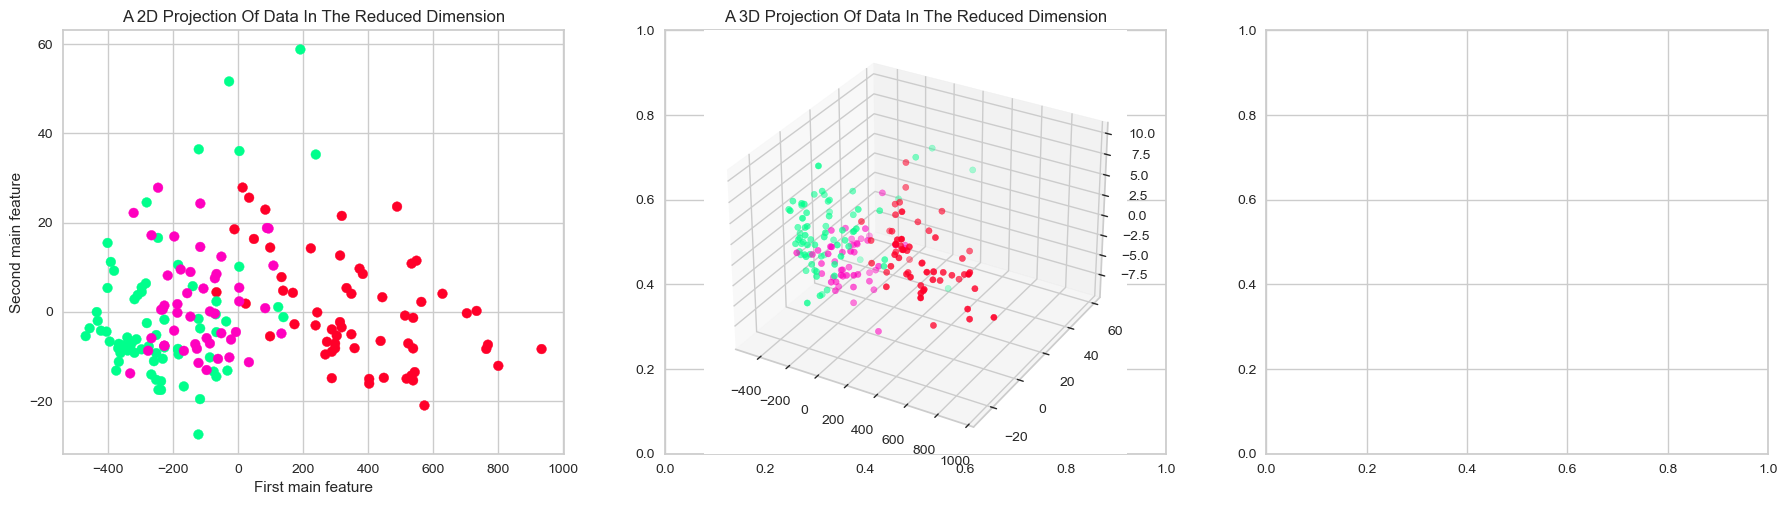

In [42]:
plt.set_cmap('gist_rainbow')
plot_graphics(x_df, y_df)

## Оценка и визуализация K-means

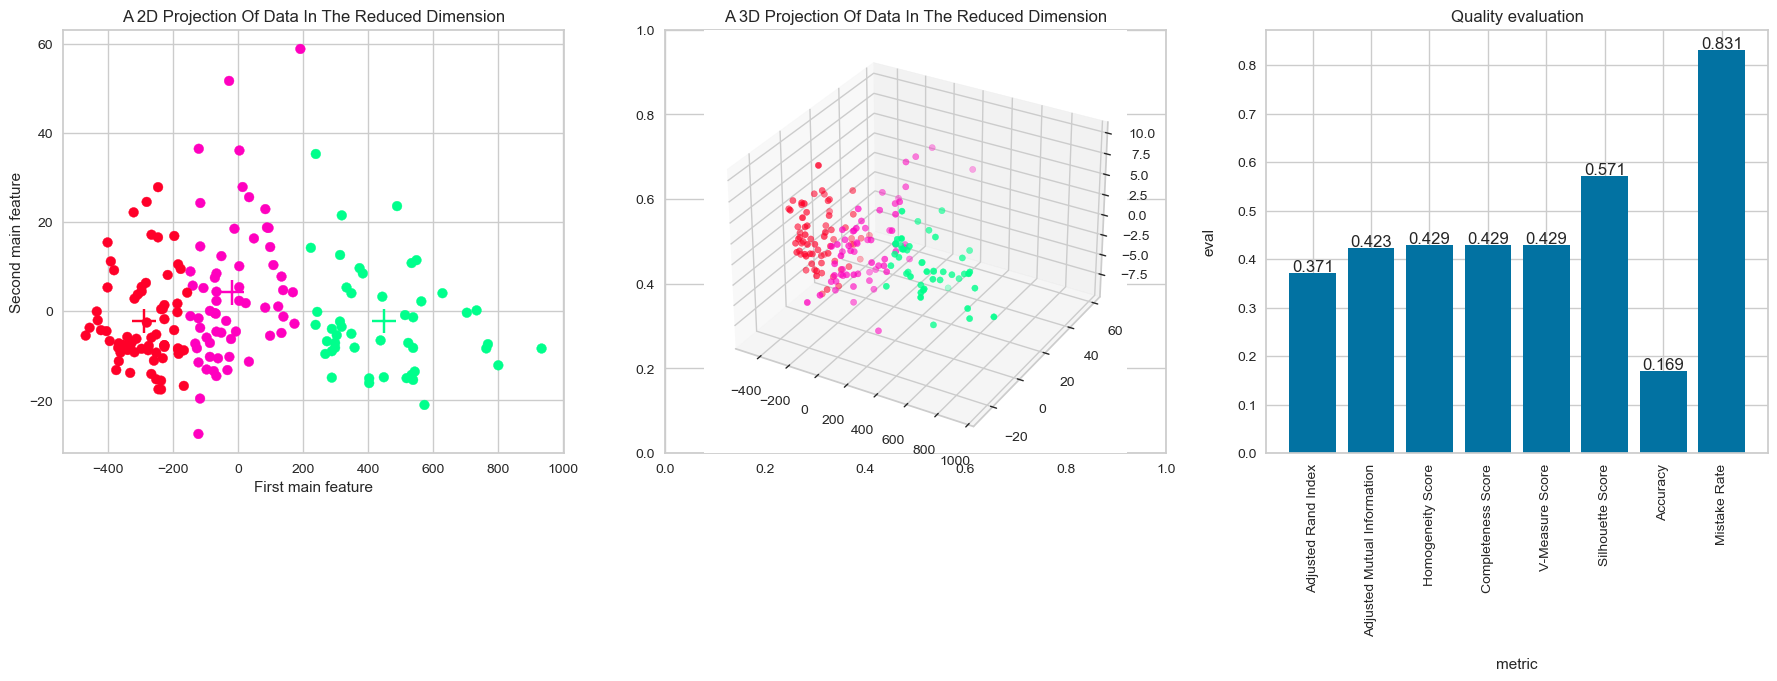

In [43]:
cl_count = np.unique(y_df if isinstance(y_df, np.ndarray) else y_df.values).size
km = KMeans(n_clusters=cl_count, random_state=42).fit(x_df)
plot_graphics(x_df, y_df, y_pred=km.labels_, c_centers=km.cluster_centers_)

## Правило локтя

In [44]:
def elbow_rule(x, title="Elbow method"):
    """
    Вычисляет оптимальное количество классов методом локтя
    :param x: данные для классификации
    :param title: заголовок метода
    :return: число классов для разбиения
    """
    visualizer = KElbowVisualizer(KMeans(random_state=42),
                                  param_grid={"n_clusters": range(1, 11)},
                                  title=title)
    visualizer.fit(x)
    visualizer.show()
    return visualizer.elbow_value_

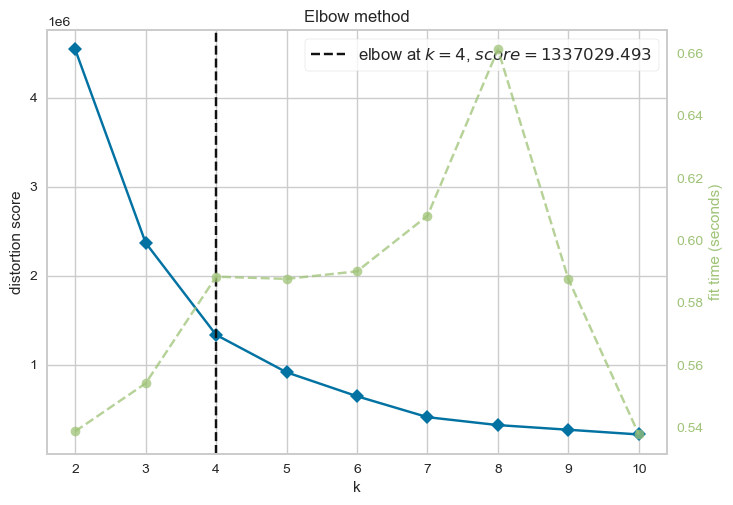

In [45]:
elbow_value = elbow_rule(x_df)

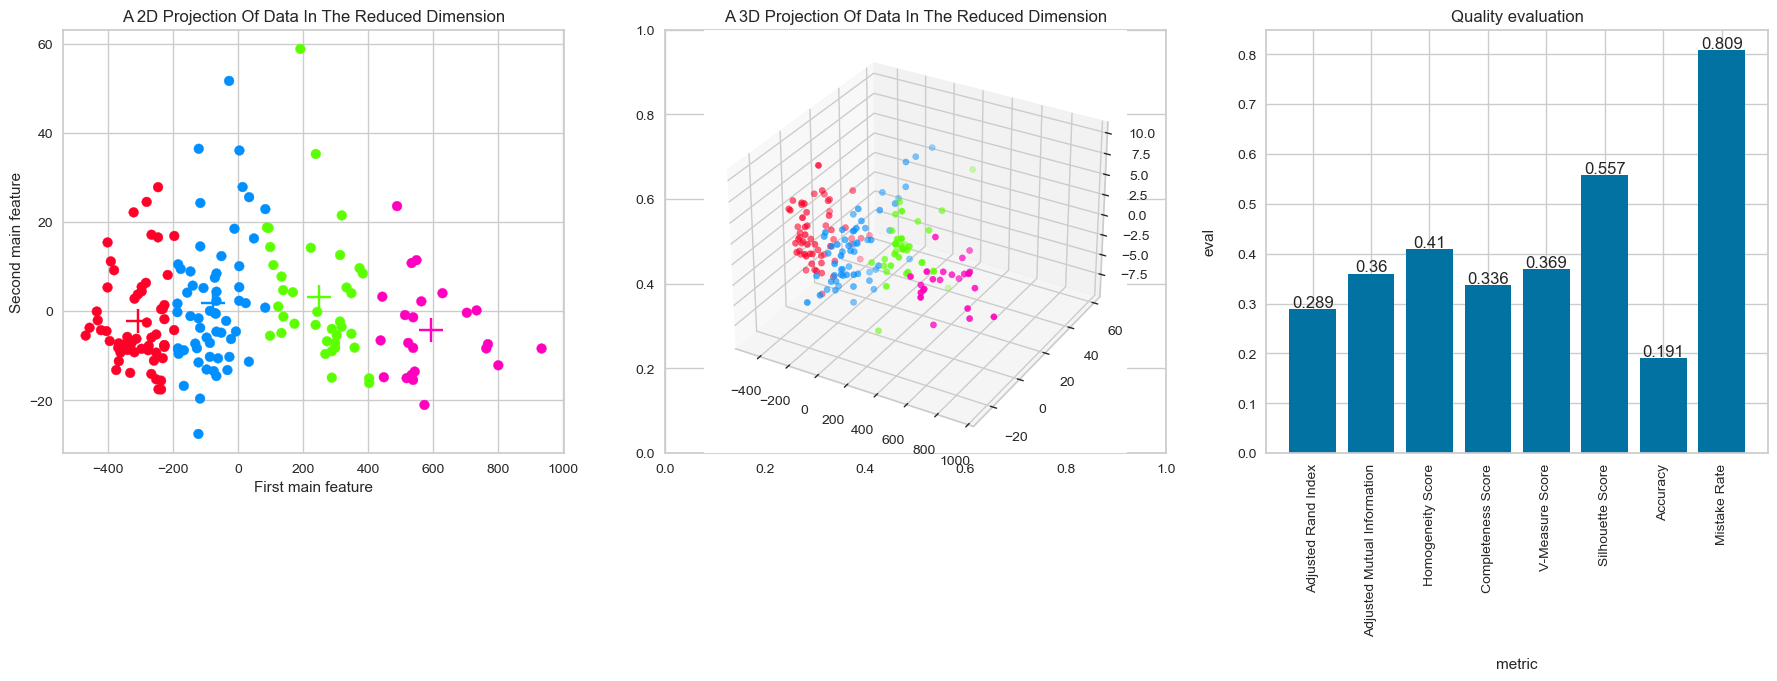

In [46]:
km = KMeans(n_clusters=elbow_value, random_state=42).fit(x_df)
plot_graphics(x_df, y_df, km.labels_, c_centers=km.cluster_centers_)

## AffinityPropagation

In [47]:
def build_af(x, y, param_grid):
    """
    Кластеризует данные при помощи алгоритма AffinityPropagation
    :param x: данные для классификации
    :param y: исходные метки классов
    :param param_grid: словарь параметров
    """
    fitted = []
    for params in ParameterGrid(param_grid):
        af = AffinityPropagation(**params, random_state=42).fit(x)
        fitted.append((af, silhouette_score(x, af.labels_)))

    af = max(fitted, key=lambda model: model[1])[0]
    n_clusters = len(af.cluster_centers_indices_)
    print(n_clusters)
    plot_graphics(x, y, af.labels_, c_centers=af.cluster_centers_)
    print(f"Model params:\n"
          f"damping={af.damping}\n"
          f"max_iter={af.max_iter}\n"
          f"clusters={n_clusters}")

7


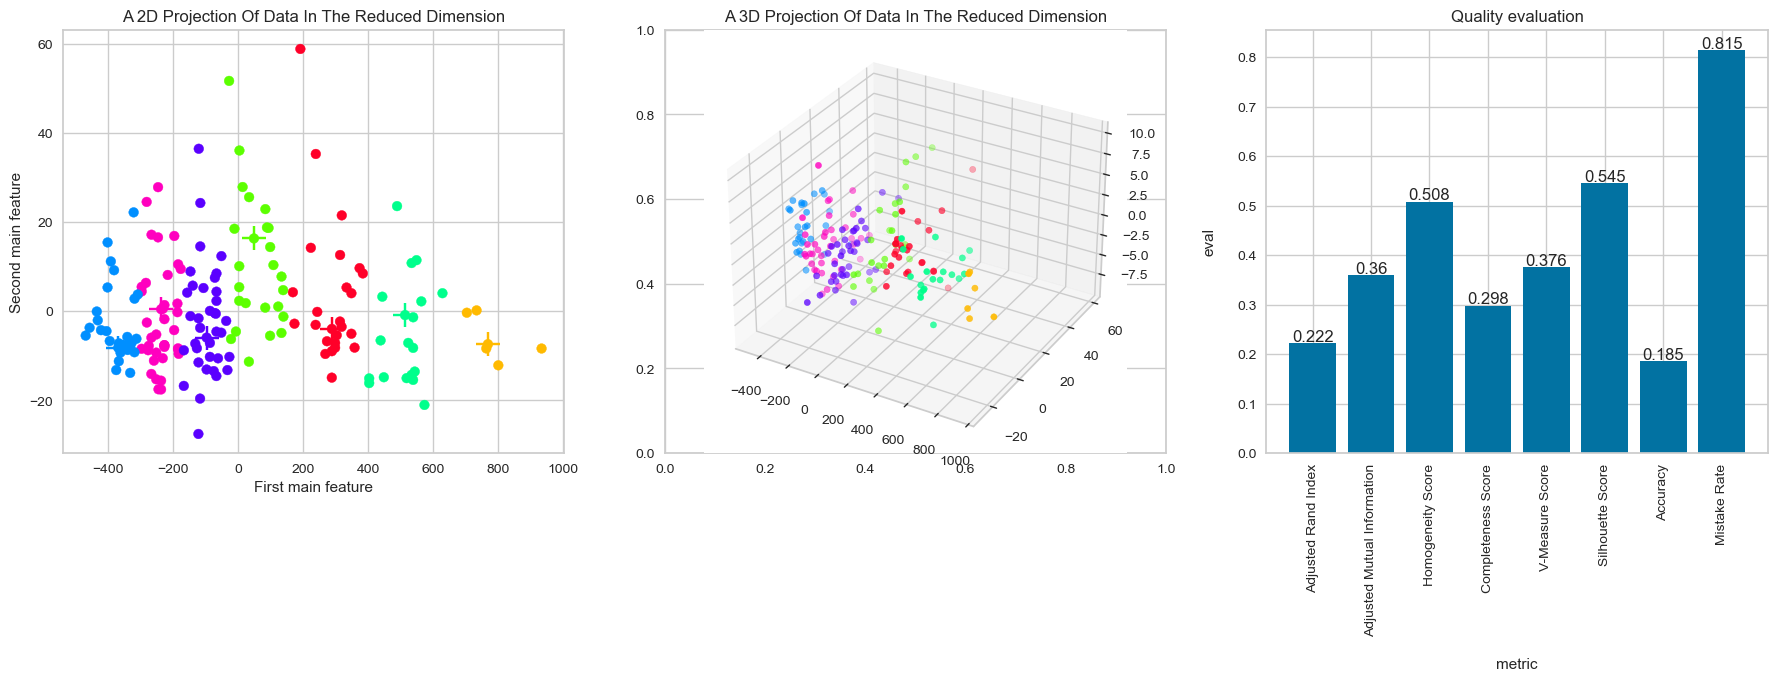

Model params:
damping=0.6
max_iter=50
clusters=7


In [48]:
param_grid_af = {
        'damping': [0.5, 0.6, 0.7, 0.8, 0.9],
        'max_iter': [50, 100, 200, 500],
    }
build_af(x_df, y_df, param_grid_af)